In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.splirent_deconv_conv_generator_concat import load_generator_network
from definitions.predictor.splirent_only_random_regions import load_saved_predictor as load_cnn_predictor
from definitions.predictor.splirent_logistic_regression_both_regions import load_saved_predictor as load_lr_predictor

from splicing_differential_genesis_helpers import *

#Load hexamer regression weights
nmer_weights = pd.read_csv('alt_5ss_6mers.csv', sep='\t')
nmers = list(nmer_weights.iloc[1:]['nmer'].values)

hek_w_0 = nmer_weights.iloc[0]['hek']
hek_w = np.array(nmer_weights.iloc[1:]['hek'].values)

hela_w_0 = nmer_weights.iloc[0]['hela']
hela_w = np.array(nmer_weights.iloc[1:]['hela'].values)

mcf7_w_0 = nmer_weights.iloc[0]['mcf7']
mcf7_w = np.array(nmer_weights.iloc[1:]['mcf7'].values)

cho_w_0 = nmer_weights.iloc[0]['cho']
cho_w = np.array(nmer_weights.iloc[1:]['cho'].values)

nmer_weights_1 = pd.read_csv('alt_5ss_6mers_both_regions_1.csv', sep='\t')
nmer_weights_2 = pd.read_csv('alt_5ss_6mers_both_regions_2.csv', sep='\t')

hek_both_regions_w_0 = nmer_weights_1.iloc[0]['hek']
hek_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['hek'].values), np.array(nmer_weights_2['hek'].values)], axis=0)

hela_both_regions_w_0 = nmer_weights_1.iloc[0]['hela']
hela_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['hela'].values), np.array(nmer_weights_2['hela'].values)], axis=0)

mcf7_both_regions_w_0 = nmer_weights_1.iloc[0]['mcf7']
mcf7_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['mcf7'].values), np.array(nmer_weights_2['mcf7'].values)], axis=0)

cho_both_regions_w_0 = nmer_weights_1.iloc[0]['cho']
cho_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['cho'].values), np.array(nmer_weights_2['cho'].values)], axis=0)


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_cnn_differential_loss(target_diff_func, region_1_start=10, region_1_end=35, region_1_target_bits=1.8, region_2_start=53, region_2_end=78, region_2_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5) :
    
    masked_entropy_mse_region_1 = get_target_entropy_sme_masked(pwm_start=region_1_start, pwm_end=region_1_end, target_bits=region_1_target_bits)
    masked_entropy_mse_region_2 = get_target_entropy_sme_masked(pwm_start=region_2_start, pwm_end=region_2_end, target_bits=region_2_target_bits)
    
    pwm_sample_entropy_func_region_1 = get_pwm_margin_sample_entropy_masked(pwm_start=region_1_start, pwm_end=region_1_end, margin=similarity_margin, shift_1_nt=True)
    pwm_sample_entropy_func_region_2 = get_pwm_margin_sample_entropy_masked(pwm_start=region_2_start, pwm_end=region_2_end, margin=similarity_margin, shift_1_nt=True)
    
    def pwm_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, hek_pred, hela_pred, mcf7_pred, cho_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(hek_pred, hela_pred, mcf7_pred, cho_pred), axis=1)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)) / 2.
        
        #Compute total loss
        total_loss = diff_loss + seq_loss + entropy_loss

        return total_loss
    
    def sample_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, hek_pred, hela_pred, mcf7_pred, cho_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(hek_pred, hela_pred, mcf7_pred, cho_pred), axis=1)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)) / 2.
        
        #Compute total loss
        total_loss = diff_loss + seq_loss + entropy_loss

        return total_loss
    
    return pwm_loss_func, sample_loss_func

#Define target isoform loss function
def get_lr_differential_loss(target_diff_func, region_1_start=10, region_1_end=35, region_1_target_bits=1.8, region_2_start=53, region_2_end=78, region_2_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, max_mer4_weight=0.0, max_mer4_count=1., max_mer6_weight=0.0, max_mer6_count=1.) :
    
    masked_entropy_mse_region_1 = get_target_entropy_sme_masked(pwm_start=region_1_start, pwm_end=region_1_end, target_bits=region_1_target_bits)
    masked_entropy_mse_region_2 = get_target_entropy_sme_masked(pwm_start=region_2_start, pwm_end=region_2_end, target_bits=region_2_target_bits)
    
    pwm_sample_entropy_func_region_1 = get_pwm_margin_sample_entropy_masked(pwm_start=region_1_start, pwm_end=region_1_end, margin=similarity_margin, shift_1_nt=True)
    pwm_sample_entropy_func_region_2 = get_pwm_margin_sample_entropy_masked(pwm_start=region_2_start, pwm_end=region_2_end, margin=similarity_margin, shift_1_nt=True)
    
    def pwm_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, mer4_count, mer6_count, score_pred, iso_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += max_mer4_weight * K.mean(K.sum(K.maximum(mer4_count - max_mer4_count, K.constant(0, shape=(1,))), axis=-1), axis=1)
        seq_loss += max_mer6_weight * K.mean(K.sum(K.maximum(mer6_count - max_mer6_count, K.constant(0, shape=(1,))), axis=-1), axis=1)
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1))
        
        #Compute total loss
        total_loss = diff_loss + seq_loss + entropy_loss

        return total_loss
    
    def sample_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, mer4_count, mer6_count, score_pred, iso_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(iso_pred), axis=1)
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1))
        
        #Compute total loss
        total_loss = diff_loss + entropy_loss

        return total_loss
    
    return pwm_loss_func, sample_loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, cnn_pwm_loss_func, cnn_sample_loss_func, lr_pwm_loss_func, lr_sample_loss_func, cnn_mix_weight, library_contexts, cnn_model_path, lr_model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Networks and hook it on the generator PWM output tensor
    _, cnn_pwm_predictor = build_predictor(generator, load_cnn_predictor(cnn_model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, cnn_sample_predictor = build_predictor(generator, load_cnn_predictor(cnn_model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in cnn_pwm_predictor.layers :
        if 'splirent' in layer.name :
            layer.name += "_pwmversion"
    
    _, lr_pwm_predictor = build_predictor(generator, load_lr_predictor(lr_model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, lr_sample_predictor = build_predictor(generator, load_lr_predictor(lr_model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in lr_pwm_predictor.layers :
        if 'mer' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Models (In: Generator seed, Out: Loss function)
    _, cnn_pwm_loss_model = build_loss_model(cnn_pwm_predictor, cnn_pwm_loss_func)
    _, cnn_sample_loss_model = build_loss_model(cnn_sample_predictor, cnn_sample_loss_func)
    
    _, lr_pwm_loss_model = build_loss_model(lr_pwm_predictor, lr_pwm_loss_func)
    _, lr_sample_loss_model = build_loss_model(lr_sample_predictor, lr_sample_loss_func)
    
    dual_loss_out = Lambda(
        lambda x: cnn_mix_weight * (0.5 * x[0] + 0.5 * x[1]) + (1. - cnn_mix_weight) * (0.5 * x[2] + 0.5 * x[3])
    )([
        cnn_pwm_loss_model.outputs[0],
        cnn_sample_loss_model.outputs[0],
        lr_pwm_loss_model.outputs[0],
        lr_sample_loss_model.outputs[0]
    ])

    loss_model = Model(inputs=cnn_pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Specify callback entities
    callbacks =[
        #EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto'),
        #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)), #Dummy training example
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    return generator, cnn_sample_predictor, train_history



In [3]:
#Specfiy file path to pre-trained predictor networks

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')
cnn_predictor_model_name = 'aparent_splirent_only_random_regions_drop_02_sgd.h5'
cnn_predictor_model_path = os.path.join(save_dir, cnn_predictor_model_name)

lr_predictor_model_path = ''


In [4]:
#Specify sequence template and differential objective

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a'
]

lr_diff_funcs = [
    lambda iso_pred: 3.0 * K.abs(K.abs(iso_pred[..., 3] - iso_pred[..., 2]) - 1.0)
]

cnn_diff_funcs = [
    lambda hek_pred, hela_pred, mcf7_pred, cho_pred: 3.0 * K.abs(K.abs(cho_pred[..., 0] - mcf7_pred[..., 0]) - 1.0)
]

cell_type_suffixes = [
    'cho_vs_mcf7'
]


In [ ]:
#Train GENESIS Network

print("Training GENESIS (Diff. Splicing)")

#Number of PWMs to generate per objective
batch_size = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 50
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

cnn_mix_weight = 0.80

K.clear_session()

cnn_pwm_loss_func, cnn_sample_loss_func = get_cnn_differential_loss(
    cnn_diff_funcs[0],
    region_1_start=10,
    region_1_end=35,
    region_1_target_bits=2.0,
    region_2_start=53,
    region_2_end=78,
    region_2_target_bits=2.0,
    entropy_weight=3.5,
    similarity_weight=7.5,
    similarity_margin=0.5,
)

lr_pwm_loss_func, lr_sample_loss_func = get_lr_differential_loss(
    lr_diff_funcs[0],
    region_1_start=10,
    region_1_end=35,
    region_1_target_bits=2.0,
    entropy_weight=3.5,
    similarity_weight=5.0,
    similarity_margin=0.4,
    max_mer4_weight=0.0,
    max_mer4_count=1.,
    max_mer6_weight=0.0,
    max_mer6_count=1.
)

genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[0]], cnn_pwm_loss_func, cnn_sample_loss_func, lr_pwm_loss_func, lr_sample_loss_func, cnn_mix_weight, [library_contexts[0]], cnn_predictor_model_path, lr_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffixes[0] + '_cnn_and_lr_only_random_regions_50_epochs_harderentropy_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffixes[0] + '_cnn_and_lr_only_random_regions_50_epochs_harderentropy_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


In [2]:
sequence_template = 'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'

cell_type_suffix = 'cho_vs_mcf7'

model_suffix = 'cnn_and_lr_only_random_regions_50_epochs_harderentropy'


cell_1, cell_2 = cell_type_suffix.split("_vs_")
cell_type_ixs = { 'hek' : 0, 'hela' : 1, 'mcf7' : 2, 'cho' : 3, }
cell_i, cell_j = cell_type_ixs[cell_1], cell_type_ixs[cell_2]

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffix + '_' + model_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffix + '_' + model_suffix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:

cnn_model_names = [
    'aparent_splirent_only_random_regions_drop_02_sgd',
    'aparent_splirent_only_random_regions_cuts_drop_02_sgd',
    'aparent_splirent_drop_02_sgd',
    'aparent_splirent_cuts_drop_02_sgd',
    'aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss',
    'aparent_splirent_drop_02_sgd_targeted_a5ss',
]

cnn_input_preps = [
    lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]],
    lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]],
    lambda x: [x[:, 5:83, :, 0]],
    lambda x: [x[:, 5:83, :, 0]],
    lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]],
    lambda x: [x[:, 5:83, :, 0]],
]

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')

cnn_predictors = [
    load_model(os.path.join(save_dir, cnn_predictor_model_name + ".h5")) for cnn_predictor_model_name in cnn_model_names
]


CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.565155
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3570313
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.54562724
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.4185541
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.50697315
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.43406776
LR pred diff = 0.336024105941369
LR pred diff (both regions) = 0.5754804506967129
Pred Diff (CNN) = 0.57


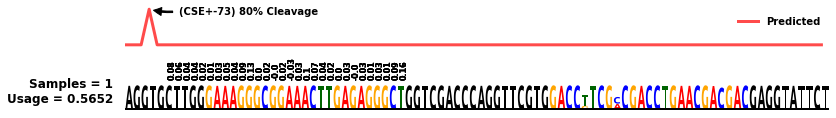

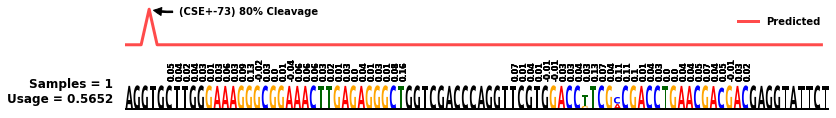

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.48850003
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.480692
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.49521142
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.36399823
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.52337146
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.45789027
LR pred diff = 0.22911045424973076
LR pred diff (both regions) = 0.44531172268758035
Pred Diff (CNN) = 0.49


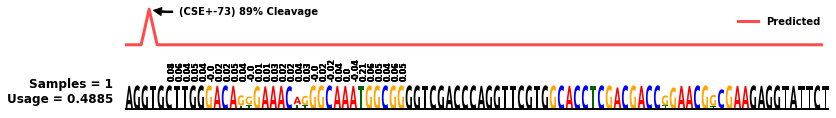

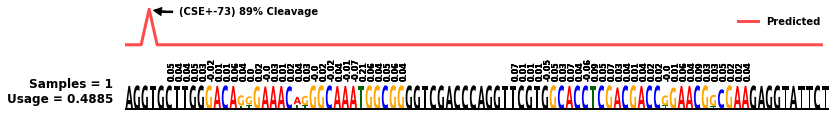

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.50166106
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.31593186
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.46279117
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.328933
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.44947577
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.38677073
LR pred diff = 0.2012924933572543
LR pred diff (both regions) = 0.40785597661713635
Pred Diff (CNN) = 0.5


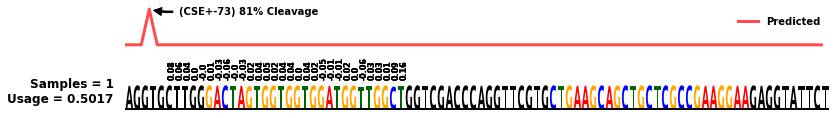

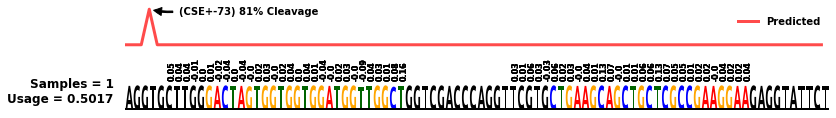

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5063879
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3028814
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5270498
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.34788442
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.42146757
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.3766805
LR pred diff = 0.16685466424935735
LR pred diff (both regions) = 0.42433626336050523
Pred Diff (CNN) = 0.51


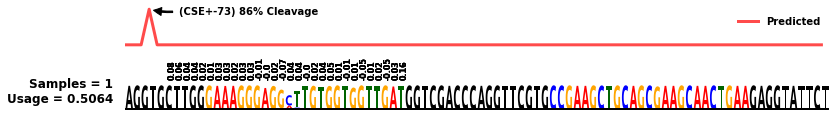

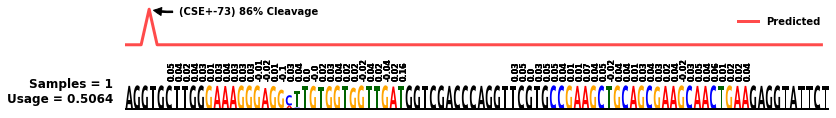

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5915742
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3097104
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.53599966
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3986696
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.52847135
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.46890408
LR pred diff = 0.2790796606171442
LR pred diff (both regions) = 0.46638130141599576
Pred Diff (CNN) = 0.59


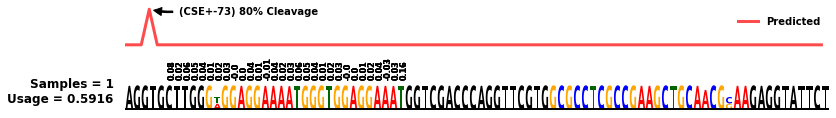

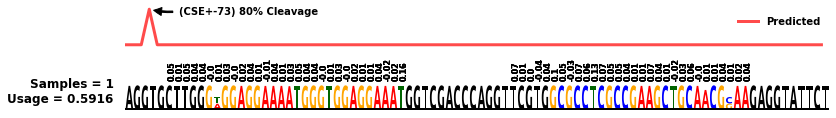

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.56534946
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.27275428
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5025159
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.35703862
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.3544542
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.19384724
LR pred diff = 0.28111366292392526
LR pred diff (both regions) = 0.43425170756441056
Pred Diff (CNN) = 0.57


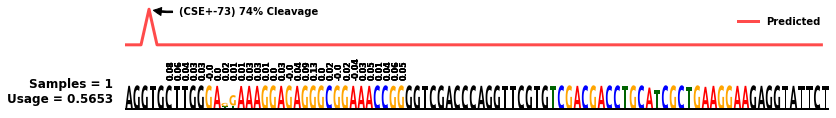

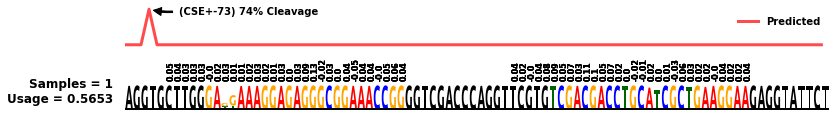

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5455406
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.29891136
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.57089555
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.40785083
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.45803913
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.33244702
LR pred diff = 0.31135293997760505
LR pred diff (both regions) = 0.5056387110941489
Pred Diff (CNN) = 0.55


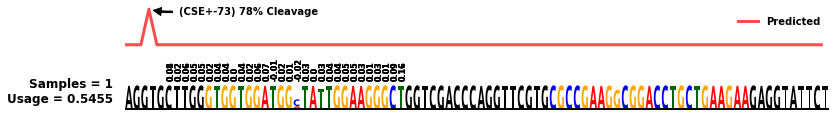

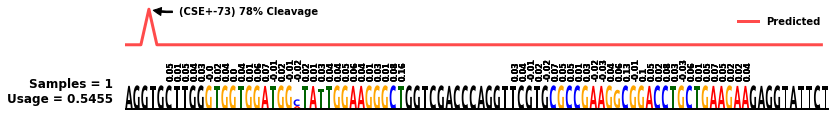

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.57750094
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.19998026
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5464487
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.32953537
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.44556472
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.3014161
LR pred diff = 0.2696851535345317
LR pred diff (both regions) = 0.36850709713657537
Pred Diff (CNN) = 0.58


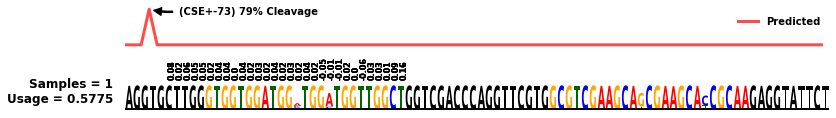

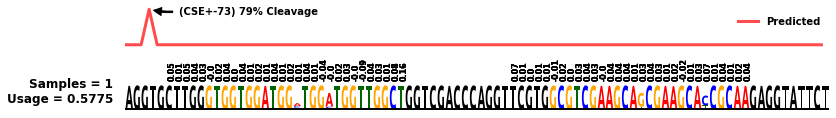

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.50584006
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.41763183
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.43564832
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.32236156
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.45400357
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.39889315
LR pred diff = 0.2754861411509093
LR pred diff (both regions) = 0.48266575811012413
Pred Diff (CNN) = 0.51


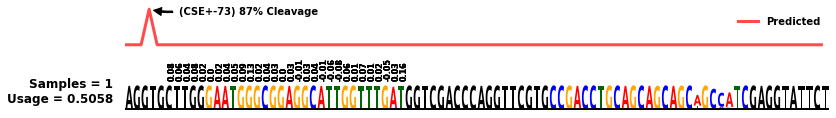

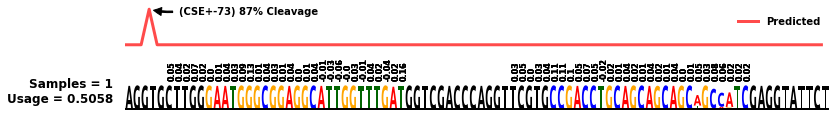

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5599674
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.46707582
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.45694083
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3903839
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.5110806
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.45361093
LR pred diff = 0.3398850162776417
LR pred diff (both regions) = 0.5511397980862565
Pred Diff (CNN) = 0.56


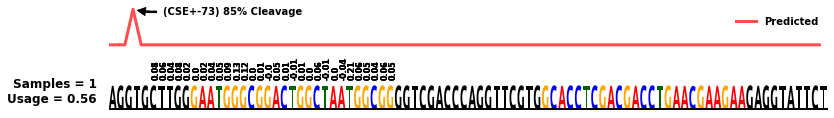

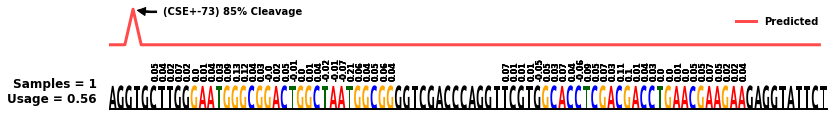

In [4]:
n = 32

sequence_class = np.array([0] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _, hek_pred, hela_pred, mcf7_pred, cho_pred = pred_outputs

onehots = sampled_pwm[:, 0, :, :, :]

iso_pred = np.concatenate([hek_pred, hela_pred, mcf7_pred, cho_pred], axis=-1)

cut_pred = np.zeros((n, 1, 109))
cut_pred[:, 0, 3] = iso_pred[:, 0, cell_i]

diff_pred = iso_pred[:, :, cell_i] - iso_pred[:, :, cell_j]

cnn_preds = [
    cnn_predictors[i].predict(x=cnn_input_preps[i](onehots), batch_size=32) for i in range(len(cnn_predictors))
]

cnn_diffs = [
    (cnn_preds[i][cell_i] - cnn_preds[i][cell_j]) for i in range(len(cnn_predictors))
]

lr_preds = get_hexamer_preds(decode_onehots_consensus(onehots))
lr_both_regions_preds = get_hexamer_preds_both_regions(decode_onehots_consensus(onehots))

lr_diffs = lr_preds[:, cell_i] - lr_preds[:, cell_j]
lr_both_regions_diffs = lr_both_regions_preds[:, cell_i] - lr_both_regions_preds[:, cell_j]

for pwm_index in range(10) :
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    diff = np.expand_dims(diff_pred[pwm_index, :], axis=-1)
    
    for i in range(len(cnn_predictors)) :
        print("CNN Model = " + str(cnn_model_names[i]) + ", pred diff = " + str(cnn_diffs[i][pwm_index, 0]))
    
    print("LR pred diff = " + str(lr_diffs[pwm_index]))
    print("LR pred diff (both regions) = " + str(lr_both_regions_diffs[pwm_index]))
    
    print("Pred Diff (CNN) = " + str(round(diff[0, 0], 2)))
    
    hexamer_diffs_both_regions = get_hexamer_diff_scores_both_regions(decode_onehot_consensus(optimized_pwm[pwm_index, :, :, 0]), cell_1, cell_2)
    hexamer_diffs = get_hexamer_diff_scores(decode_onehot_consensus(optimized_pwm[pwm_index, :, :, 0]), cell_1, cell_2)
    
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs_both_regions, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)

In [3]:
#Generate 3,200 sequences

n = 32 * 100

sequence_class = np.array([0] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _, hek_pred, hela_pred, mcf7_pred, cho_pred = pred_outputs

onehots = sampled_pwm[:, 0, :, :, :]

iso_pred = np.concatenate([hek_pred, hela_pred, mcf7_pred, cho_pred], axis=-1)

cut_pred = np.zeros((n, 1, 109))
cut_pred[:, 0, 3] = iso_pred[:, 0, cell_i]

diff_pred = iso_pred[:, :, cell_i] - iso_pred[:, :, cell_j]


CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6344135
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3594277
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.53039324
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.40407687
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.48813283
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.4469012
LR pred diff = 0.34482389685910153
LR pred diff (both regions) = 0.5743682740958256
Pred Diff (CNN) = 0.63


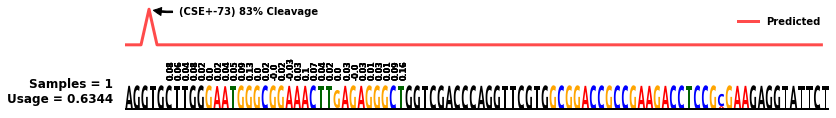

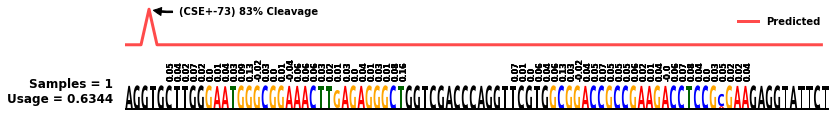

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.63282484
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.31403056
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.58644044
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.40784478
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4950311
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.32125172
LR pred diff = 0.25593963851013324
LR pred diff (both regions) = 0.5767440626857786
Pred Diff (CNN) = 0.63


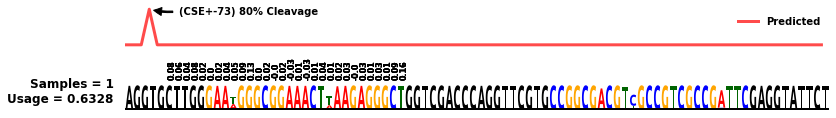

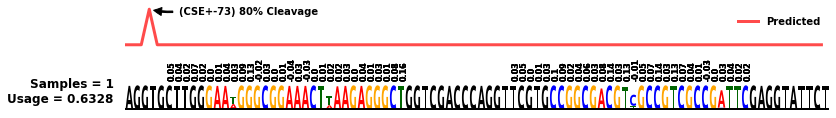

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.629027
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.351853
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.55324703
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.43976563
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.54873335
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.46233198
LR pred diff = 0.3222679332047859
LR pred diff (both regions) = 0.5017207064933403
Pred Diff (CNN) = 0.63


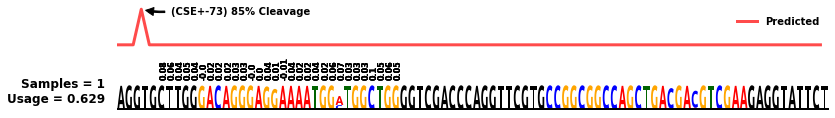

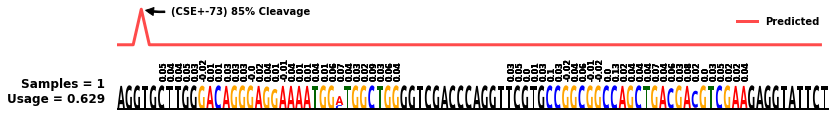

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.62885374
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.28453094
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5780631
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.30290997
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4752107
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.3943656
LR pred diff = 0.34482389685910153
LR pred diff (both regions) = 0.5518930539061409
Pred Diff (CNN) = 0.63


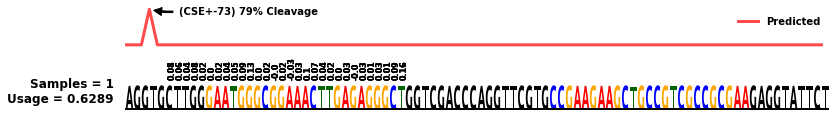

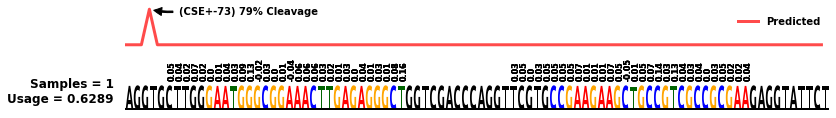

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6285325
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.23649362
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.56230986
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.40809208
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.44043174
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.4228564
LR pred diff = 0.3124744604383159
LR pred diff (both regions) = 0.5349559388255943
Pred Diff (CNN) = 0.63


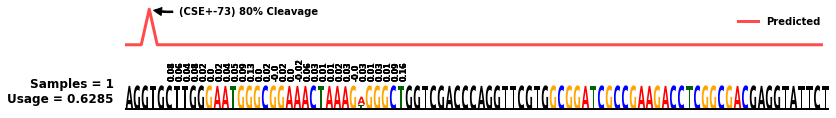

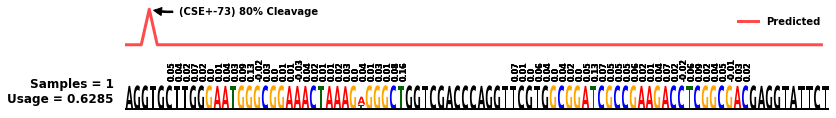

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.62842107
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.33616918
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5956582
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.4499259
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.52580416
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.47897035
LR pred diff = 0.2670444053684716
LR pred diff (both regions) = 0.47835903290240167
Pred Diff (CNN) = 0.63


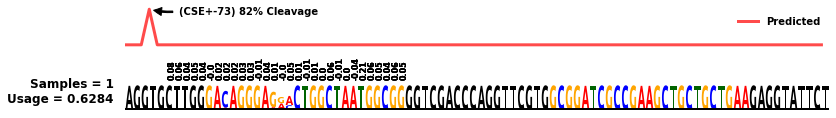

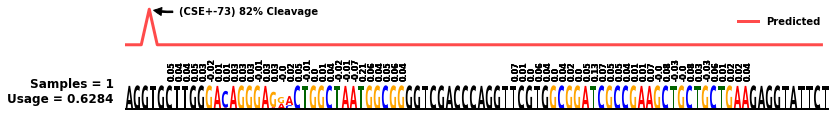

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.62831235
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3019187
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.555022
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.34801292
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.5567081
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.45507565
LR pred diff = 0.2897709123862788
LR pred diff (both regions) = 0.467137062146019
Pred Diff (CNN) = 0.63


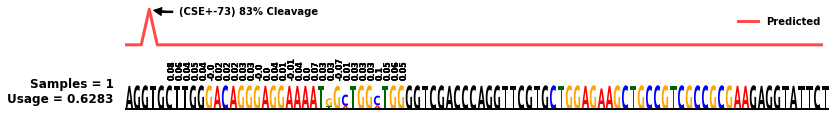

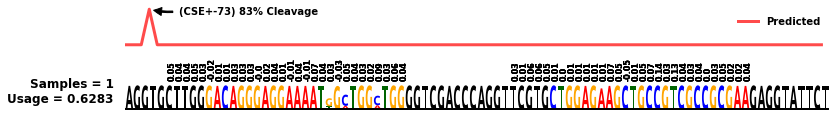

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6241981
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.16733277
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.49692804
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.21343118
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.33394423
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.33301687
LR pred diff = 0.3908664961420858
LR pred diff (both regions) = 0.5236232179259086
Pred Diff (CNN) = 0.62


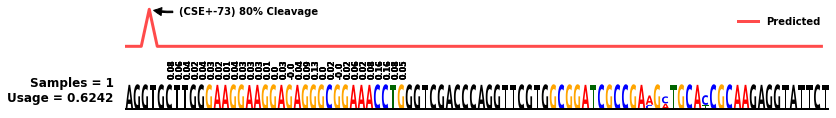

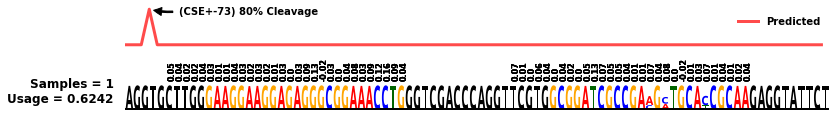

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6236638
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3716959
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5055821
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.45288846
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.43369055
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.44438964
LR pred diff = 0.32179819340792637
LR pred diff (both regions) = 0.5239110087296155
Pred Diff (CNN) = 0.62


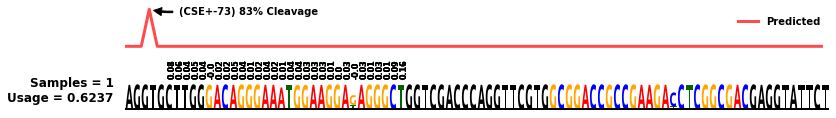

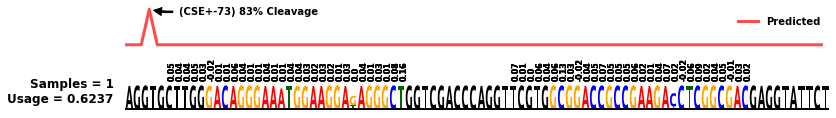

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6232116
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.23650876
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5582461
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.31372446
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.35654163
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.22898963
LR pred diff = 0.4145151273882392
LR pred diff (both regions) = 0.6249967033018791
Pred Diff (CNN) = 0.62


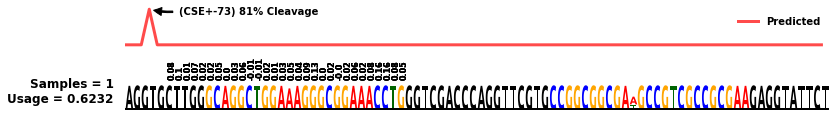

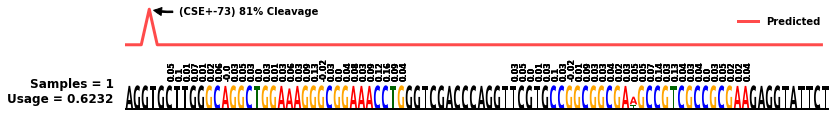

In [6]:
#Sort and plot top 10 sequences

sort_index = np.argsort(np.abs(diff_pred[:, 0]))[::-1]
keep_index = sort_index[:10]

optimized_pwm_kept = optimized_pwm[keep_index]
onehots_kept = onehots[keep_index]
iso_pred_kept = iso_pred[keep_index]
cut_pred_kept = cut_pred[keep_index]
diff_pred_kept = diff_pred[keep_index]



cnn_preds = [
    cnn_predictors[i].predict(x=cnn_input_preps[i](onehots_kept), batch_size=32) for i in range(len(cnn_predictors))
]

cnn_diffs = [
    (cnn_preds[i][cell_i] - cnn_preds[i][cell_j]) for i in range(len(cnn_predictors))
]

lr_preds = get_hexamer_preds(decode_onehots_consensus(onehots_kept))
lr_both_regions_preds = get_hexamer_preds_both_regions(decode_onehots_consensus(onehots_kept))

lr_diffs = lr_preds[:, cell_i] - lr_preds[:, cell_j]
lr_both_regions_diffs = lr_both_regions_preds[:, cell_i] - lr_both_regions_preds[:, cell_j]

for pwm_index in range(10) :
    
    pwm = np.expand_dims(optimized_pwm_kept[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred_kept[pwm_index, 0, :], axis=0)
    diff = np.expand_dims(diff_pred_kept[pwm_index, :], axis=-1)
    
    for i in range(len(cnn_predictors)) :
        print("CNN Model = " + str(cnn_model_names[i]) + ", pred diff = " + str(cnn_diffs[i][pwm_index, 0]))
    
    print("LR pred diff = " + str(lr_diffs[pwm_index]))
    print("LR pred diff (both regions) = " + str(lr_both_regions_diffs[pwm_index]))
    
    print("Pred Diff (CNN) = " + str(round(diff[0, 0], 2)))
    
    hexamer_diffs_both_regions = get_hexamer_diff_scores_both_regions(decode_onehot_consensus(optimized_pwm_kept[pwm_index, :, :, 0]), cell_1, cell_2)
    hexamer_diffs = get_hexamer_diff_scores(decode_onehot_consensus(optimized_pwm_kept[pwm_index, :, :, 0]), cell_1, cell_2)
    
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="top_diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs_both_regions, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="top_diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)

In [4]:
#Load splicing MPRA test set
pred_df = pd.read_csv('a5ss_test_pred_aparent_splirent_only_random_regions_drop_02_sgd.csv', sep='\t')


Mean MPRA Pred SD1 Diff = 0.0818
Std MPRA Pred SD1 Diff = 0.0734
Mean GENESIS Pred SD1 Diff = 0.5398
Std GENESIS Pred SD1 Diff = 0.044


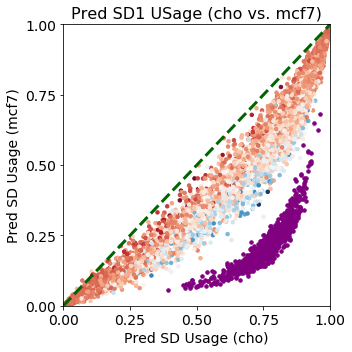

In [5]:
#Plot cell type dPSI scatter of generated sequences, together with MPRA test set

save_figs = False

mean_mpra_diff_pred = np.mean(pred_df['sd1_pred_' + cell_1] - pred_df['sd1_pred_' + cell_2])
std_mpra_diff_pred = np.std(pred_df['sd1_pred_' + cell_1] - pred_df['sd1_pred_' + cell_2])

mean_genesis_diff_pred = np.mean(iso_pred[:1000, 0, cell_i] - iso_pred[:1000, 0, cell_j])
std_genesis_diff_pred = np.std(iso_pred[:1000, 0, cell_i] - iso_pred[:1000, 0, cell_j])

print("Mean MPRA Pred SD1 Diff = " + str(round(mean_mpra_diff_pred, 4)))
print("Std MPRA Pred SD1 Diff = " + str(round(std_mpra_diff_pred, 4)))
print("Mean GENESIS Pred SD1 Diff = " + str(round(mean_genesis_diff_pred, 4)))
print("Std GENESIS Pred SD1 Diff = " + str(round(std_genesis_diff_pred, 4)))

f = plt.figure(figsize=(5, 5))

min_delta = np.min(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
max_delta = np.max(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
max_abs_delta = np.abs(np.max(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1]))

plt.scatter(pred_df['sd1_pred_' + cell_1], pred_df['sd1_pred_' + cell_2], c=pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1], cmap='RdBu_r', vmin=min_delta, vmax=max_delta, s=12, alpha=0.95)

plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

#Plot optimized dots
plt.scatter(iso_pred[:1000, 0, cell_i], iso_pred[:1000, 0, cell_j], c='purple', s=12, alpha=1.0)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('Pred SD Usage (' + cell_1 + ')', fontsize=14)
plt.ylabel('Pred SD Usage (' + cell_2 + ')', fontsize=14)
plt.title('Pred SD1 USage (' + cell_1 + ' vs. ' + cell_2 +')', fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pred_scatter"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()